In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
#import seaborn as sns
from sklearn.metrics import mean_squared_error

from keras.layers.advanced_activations import LeakyReLU
import os
from pandas import DataFrame
from numpy import concatenate

from sklearn.model_selection import GridSearchCV
import datetime
from math import sqrt
from keras import regularizers
import math
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN

In [4]:
# fix random seed for reproducibility
np.random.seed(7)

In [5]:
def remove_outliers(data, threshold=5):
    mean= data.mean()
    std= data.std()
    idx= np.abs((data-mean)/std) <= threshold
    return data[idx].reshape(-1, 1)

In [6]:
#********Load data**************************

dataset = pd.read_csv('../Paper1/spamkevin.csv', usecols=[0])
dataset.dropna(0,inplace= True)
dataset= np.array(dataset)
print('dataset with outlier', dataset.shape)
dataset= dataset.astype('float32')
dataset= remove_outliers(dataset)
print('dataset after removing outlier', dataset.shape)

# *****************split into train and test sets********************

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
data_train = dataset[0:train_size]
data_test = dataset[train_size:len(dataset)]
print('Data_train', data_train.shape, 'Data_test',data_test.shape)

# ********Normalize the data******************

scaler= MinMaxScaler (feature_range= (-1,1))
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)
print('Train_scaled',train_scaled.shape,' Test scaled', test_scaled.shape)

dataset with outlier (13544, 1)
dataset after removing outlier (13463, 1)
Data_train (10770, 1) Data_test (2693, 1)
Train_scaled (10770, 1)  Test scaled (2693, 1)


In [7]:
# ******************frame a sequence as a supervised learning problem*************

def prepare_seq2seq_data(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


look_back = 3
train_X, train_y = prepare_seq2seq_data(train_scaled , look_back)
test_X, test_y = prepare_seq2seq_data(test_scaled , look_back)

print('train_X',train_X.shape, 'train_y',train_y.shape)
print('test_X', test_X.shape, 'test_y',test_y.shape)

train_X (10766, 3) train_y (10766,)
test_X (2689, 3) test_y (2689,)


In [8]:
#*******Reshape from[samples, timesteps] into [samples, timesteps, features]*************

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
print('train_X',train_X.shape, 'train_y',train_y.shape)
print('test_X', test_X.shape, 'test_y',test_y.shape)

# convert 1 D to 2D array
#test_y = test_y.reshape((test_y.shape[0], 1))
#print(test_y.shape)

train_X (10766, 3, 1) train_y (10766,)
test_X (2689, 3, 1) test_y (2689,)


In [9]:
#**********RPE******************************
def rpe(y_true, y_pred):
    
    return backend.abs((y_pred - y_true)/y_true) * 100

In [10]:
#********************Build Model****************************

def build_model (activation):
    
    model = tf.keras.models.Sequential()
    model.add(SimpleRNN(128, input_shape=(look_back, 1),kernel_initializer='glorot_uniform',activation=activation,
                   return_sequences= True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(64,kernel_initializer='glorot_uniform', activation=activation ))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.summary()
    
     #optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer= 'adam', loss='mean_squared_error', metrics= [rpe])
    model.fit (train_X, train_y)
    
    return model


# relu

In [11]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]


model =build_model('relu')

history1 = model.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 1000, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 3, 128)            16640     
_________________________________________________________________
dropout (Dropout)            (None, 3, 128)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
10766/10766 [==============================] - 1s 120us/sample - loss: 0.0891 - rpe: 34.8516
Train on 8612 samples, va

In [12]:
# **************************Model Performance Error  metrics*************************************

hist1 = pd.DataFrame(history1.history)
hist1['epoch'] = history1.epoch
print(hist1.tail())

# save results
hist1.to_csv('Activation_relu_RNN.csv')

         loss        rpe  val_loss    val_rpe  epoch
995  0.031852  22.014788  0.026638  19.491251    995
996  0.032013  22.283117  0.026305  19.308060    996
997  0.031762  22.002512  0.026147  19.363991    997
998  0.031904  22.185225  0.026128  19.408720    998
999  0.031955  22.133049  0.026147  19.281870    999


# Tanh

In [13]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]


model =build_model('tanh')

history2 = model.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 1000, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 3, 128)            16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 128)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
10766/10766 [==============================] - 1s 118us/sample - loss: 0.1306 - rpe: 38.8424
Train on 8612 samples, 

In [14]:
# **************************Model Performance Error  metrics*************************************

hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
print(hist2.tail())

# save results
hist2.to_csv('Activation_tanh_RNN.csv')

         loss        rpe  val_loss    val_rpe  epoch
995  0.033687  22.687017  0.025954  19.677967    995
996  0.034132  22.988075  0.025987  19.863438    996
997  0.033834  23.005198  0.026151  19.858252    997
998  0.033844  22.725460  0.026124  19.889517    998
999  0.033996  22.946642  0.026018  19.728958    999


# sigmoid

In [15]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]


model =build_model('sigmoid')

history3 = model.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 1000, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 3, 128)            16640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 128)            0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
10766/10766 [==============================] - 1s 109us/sample - loss: 0.1888 - rpe: 46.7765
Train on 8612 samples, 

In [16]:
# **************************Model Performance Error  metrics*************************************

hist3 = pd.DataFrame(history3.history)
hist3['epoch'] = history3.epoch
print(hist3.tail())

# save results
hist3.to_csv('Activation_sigmoid_RNN.csv')

         loss        rpe  val_loss    val_rpe  epoch
995  0.032944  22.608736  0.026574  19.396425    995
996  0.032860  22.482962  0.026519  19.427803    996
997  0.033187  22.666864  0.026306  19.298180    997
998  0.033231  22.960041  0.026537  19.450043    998
999  0.032866  22.561527  0.026555  19.411663    999


# selu

In [17]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]


model =build_model('selu')

history4 = model.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 1000, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 3, 128)            16640     
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 128)            0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
10766/10766 [==============================] - 1s 132us/sample - loss: 0.3252 - rpe: 54.8180
Train on 8612 samples, 

In [18]:
# **************************Model Performance Error  metrics*************************************

hist4 = pd.DataFrame(history4.history)
hist4['epoch'] = history4.epoch
print(hist4.tail())

# save results
hist4.to_csv('Activation_selu_RNN.csv')

         loss        rpe  val_loss    val_rpe  epoch
995  0.034114  23.098114  0.026204  19.901243    995
996  0.033997  23.030680  0.026223  19.840725    996
997  0.034116  22.948586  0.026193  19.868469    997
998  0.033899  22.911409  0.026191  19.817596    998
999  0.033968  22.947838  0.026110  19.772572    999


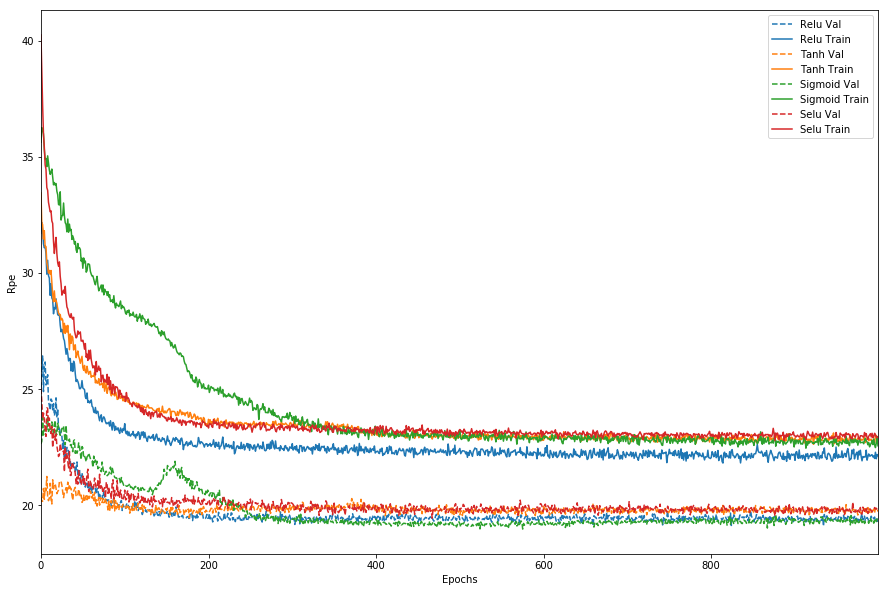

In [19]:
def plot_history(histories, key=  'rpe'):
  plt.figure(figsize=(15,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('relu', history1),
         
             ('tanh', history2),
             ('sigmoid', history3),
             ('selu', history4)])

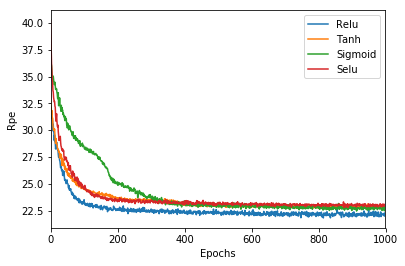

In [23]:
def plot_history(histories, key=  'rpe'):
  #plt.figure(figsize=(15,10))
    
  for name, history in histories:
    
    
    plt.plot(history.epoch, history.history[key],
             label=name.title())

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('relu', history1),
         
             ('tanh', history2),
             ('sigmoid', history3),
             ('selu', history4)])